<a href="https://colab.research.google.com/github/karasumarap/Estimating-the-behavior/blob/main/%E6%88%90%E6%9E%9C%E7%89%A9_%E3%82%BB%E3%83%B3%E3%82%B5%E3%83%87%E3%83%BC%E3%82%BF%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E9%AB%98%E9%BD%A2%E8%80%85%E3%81%AE%E8%A1%8C%E5%8B%95%E6%8E%A8%E5%AE%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import matplotlib.pyplot as plt
import csv, os
import pandas as pd
import numpy as np
import datetime

#CSVファイルからdfへ変換
csvname="　"
df = pd.read_csv(csvname)
csvname1=""
df1 = pd.read_csv(csvname1)

#日付データをdatetime型に変更
df['Time'] = pd.to_datetime(df['Time'])
df1['Time'] = pd.to_datetime(df1['Time'])

In [16]:
#状態推定関数の定義
#1分おき用に書き直し　起床、就寝、外出をすべていっきに判定するプログラム　状態を保存 5時間以上睡眠を追加　state4=5時間以上寝ている 時間をシビアに考慮 state4から起床してから3hはstate4には戻らない。

def behavior_predict(df):
  dflen=len(df)

  wakeupcount=0
  wakeupflg=1
  wakeupday=0

  sleepcount=0
  sleepflg=0
  sleepday=0

  outcount=0
  outflg=0
  outday=0

  gohomecount=0
  gohomeflg=0
  gohomeday=0

  unusual=0

  timeclock=0

  Actionlist=[]

  n = 31  # 1の個数
  StateList = [1] * n


  #状態 1寝てて在宅　2が起きてて在宅　3が起きてて外出
  state=1


  for i in range(31,dflen):
    #print(timeclock)
    if(timeclock>0):
      timeclock=timeclock-1
    #print([df.iloc[i][1],state])
    df06l=df.iloc[i:i+30,4]   #照度
    df713l=df.iloc[i-30:i,4] #高速化のため

    df06n=df.iloc[i:i+30,6]
    df713n=df.iloc[i-30:i,6] #騒音

    nowlmean=df06l.mean() #現在から6データ先までの照度平均値
    nowl60mean=df.iloc[i-300:i,4].mean() #現在から60データ前までの照度平均値
    nowlstd= df06l.std()
    nownmean=df06n.mean() #現在から6データ先までの騒音平均値
    nownstd= df06n.std()


    oldlmean=df713l.mean() #現在から6データ前までの照度平均値
    oldlstd=df713l.std()
    oldnmean=df713n.mean() #現在から6データ前までの騒音平均値
    oldnstd=df713n.std()
    StateList.append(state)


    if(state==1):
      #state1は在宅で寝てる状態
      if(nowl60mean<2 and timeclock==0):
        state=4
        wakeupcount=0
        sleepcount=0
        outcount=0
        gohomecount=0
        Actionlist.append([df.iloc[i,1],"state1→4"])



      #起床判定
      if(nowlmean+nowlstd<oldlmean+oldlstd and nownmean+nownstd<oldnmean+oldnstd):
        wakeupcount=wakeupcount+1
      #print(wakeupcount)
      if(wakeupcount>=6):
        state=2  #起床が確認されたらstate==2に移行
        wakeupcount=0
        sleepcount=0
        outcount=0
        gohomecount=0
        Actionlist.append([df.iloc[i,1],"目覚めました"])

      if((nowlmean+nowlstd<oldlmean+oldlstd and nownmean+nownstd<oldnmean+oldnstd)==0):
        wakeupcount=0



    elif(state==2):

      if(nowl60mean<2 and timeclock==0):
        state=4
        wakeupcount=0
        sleepcount=0
        outcount=0
        gohomecount=0
        Actionlist.append([df.iloc[i,1],"state2→4"])


      #就寝判定
      if(nowlmean+nowlstd>oldlmean+oldlstd and nownmean+nownstd>oldnmean+oldnstd):
        sleepcount=sleepcount+1
        #print(sleepcount)
        if(sleepcount>=6):
          state=1
          wakeupcount=0
          sleepcount=0
          outcount=0
          gohomecount=0
          Actionlist.append([df.iloc[i,1],"寝ました"])

        # print("ff")

      if((nowlmean+nowlstd>oldlmean+oldlstd and nownmean+nownstd>oldnmean+oldnstd)==0):
        sleepcount=0

      if(df.iloc[i,4]<2):

        print(state)
        unusual=unusual+1
        state=1
        print(state)
        Actionlist.append([df.iloc[i,1],"就寝状態に戻しました"])


      #外出判定
      if(nownmean<=oldnmean):
        outcount=outcount+1
        #print(outcount)
        if(outcount>=6):
          outflg=1
          state=3
          wakeupcount=0
          sleepcount=0
          outcount=0
          gohomecount=0
          Actionlist.append([df.iloc[i,1],"外出し始めました"])

      if(nownmean>oldnmean):
        outcount=0
        outflg=0

    elif(state==3):

      if(nowl60mean<2 and timeclock==0):
        state=4
        wakeupcount=0
        sleepcount=0
        outcount=0
        gohomecount=0
        Actionlist.append([df.iloc[i,1],"state3→4"])


      #起床判定
      if(nowlmean+nowlstd<oldlmean+oldlstd and nownmean+nownstd<oldnmean+oldnstd):
        wakeupcount=wakeupcount+1
      #print(wakeupcount)
      if(wakeupcount>=6):
        state=2  #起床が確認されたらstate==2に移行
        wakeupcount=0
        sleepcount=0
        outcount=0
        gohomecount=0
        Actionlist.append([df.iloc[i,1],"外出中→起床"])

      if((nowlmean+nowlstd<oldlmean+oldlstd and nownmean+nownstd<oldnmean+oldnstd)==0):
        wakeupcount=0


      if(nownmean>=oldnmean):
        gohomecount=gohomecount+1
        #print(outcount)
        if(gohomecount>=6):
          state=2
          wakeupcount=0
          sleepcount=0
          outcount=0
          gohomecount=0
          Actionlist.append([df.iloc[i,1],"帰宅しました"])

      if(nownmean<oldnmean):
        gohomecount=0

    elif(state==4):
      if(nowlmean>3 and oldlmean<0.5):
        state=2
        wakeupcount=0
        sleepcount=0
        outcount=0
        gohomecount=0
        Actionlist.append([df.iloc[i,1],"state4→2"])
        timeclock=36





    else:
      print("緊急事態")


  print(unusual)

  #csvの右側に状態を書き込み
  df["state"]=StateList


  #csvの出力 このipynbのファイルの位置に保存される
  a=csvname+".csv"

  now = datetime.datetime.now()
  filename =  now.strftime('%Y%m%d_%H%M%S') + 'B9判定条件.csv'
  df.to_csv(filename)
  print("csvに出力完了")

  return df, Actionlist




おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
4
1
55
csvに出力完了
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2
1
おかしくね？
2


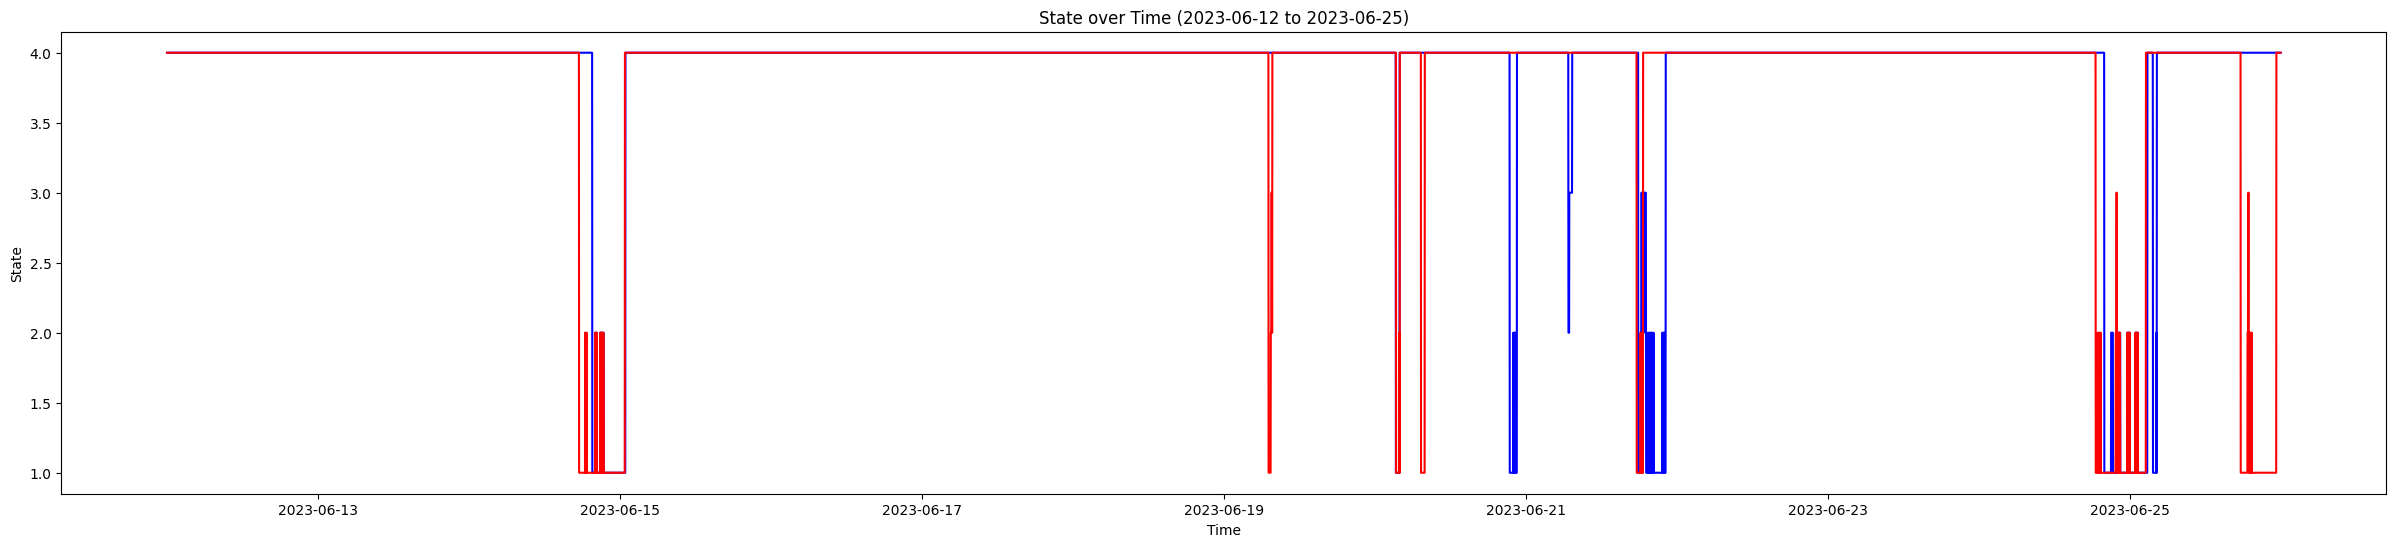

In [17]:

#状態推定　（関数内でcsvの書き出しをしている。）
data1=behavior_predict(df)
data2=behavior_predict(df1)

##2つのセンサデータ情報の統合
df_merge=data1[0].merge(data2[0], on ="Time", how="left")
df_merge = df_merge.dropna(subset=['state_y'])
df_merge['state_y'] = df_merge['state_y'].astype('int')

start_date = pd.to_datetime('2023-06-12 00:00:00')
end_date = pd.to_datetime('2023-06-25 23:59:59')

# 指定期間のデータを抽出
mask = (df_merge['Time'] >= start_date) & (df_merge['Time'] <= end_date)
df_merge_filtered = df_merge.loc[mask]

# 状態推移を表すグラフの表示
plt.figure(figsize=(30, 6))
plt.plot(df_merge_filtered['Time'], df_merge_filtered['state_x'],color='blue', label='df')
plt.plot(df_merge_filtered['Time'], df_merge_filtered['state_y'],color='red', label='df1')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('State over Time ({} to {})'.format(start_date.date(), end_date.date()))
plt.show()